PyTorch vs. Keras

PyTorch: Mathmeticians, experienced researchers; faster than Keras and has better debugging capabilities, outstanding community support and active development.

Keras: developers; a plug-and-play framework that lets them build, train, and evaluate their models quickly. Keras also offers more deployment options and easier model export, offers more deployment options and easier model export, excellent access to reusable code and tutorials, small datasets, rapid prototyping, and multiple back-end support.  It runs on Linux, MacOS, and Windows. 



|                                  |                     **Keras**                    |            **PyTorch**           |          **TensorFlow**          |
|:--------------------------------:|:------------------------------------------------:|:--------------------------------:|:--------------------------------:|
|           **API Level**          |                       High                       |                Low               |           High and Low           |
|         **Architecture**         |             Simple, concise, readable            |      Complex, less readable      |          Not easy to use         |
|           **Datasets**           |                 Smaller datasets                 | Large datasets, high performance | Large datasets, high performance |
|           **Debugging**          | Simple network, so debugging is not often needed |    Good debugging capabilities   |  Difficult to conduct debugging  |
| **Does It Have Trained Models?** |                        Yes                       |                Yes               |                Yes               |
|          **Popularity**          |                   Most popular                   |        Third most popular        |        Second most popular       |
|             **Speed**            |               Slow, low performance              |      Fast, high-performance      |      Fast, high-performance      |
|          **Written In**          |                      Python                      |                Lua               |         C++, CUDA, Python        |



Reference: https://www.simplilearn.com/keras-vs-tensorflow-vs-pytorch-article#:~:text=TensorFlow%20offers%20better%20visualization%2C%20which,to%20the%20TensorFlow%20Serving%20framework.

### Import package

In [10]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data
import tensorflow as tf
import pandas as pd  
import numpy as np
from  sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")

## Generate Train and Test

In [11]:
SNP = pd.read_csv('../Data/raw/SNPTSX.csv', parse_dates=['Date'])
SNP.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)

<AxesSubplot:xlabel='Date'>

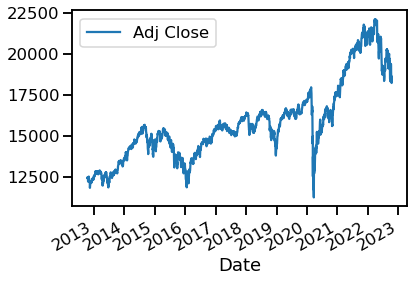

In [12]:
SNP.set_index('Date').plot()

In [13]:
dataset = SNP.set_index('Date').loc['2016-01-01':'2017-01-31','Adj Close']
dataset = np.array(dataset.astype('float32')).reshape(-1,1)

## Train Model

In [14]:
def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

dataset=norm(dataset)

look_back=8
np.random.seed(7)
train_size = int(len(dataset) * 0.99)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

def create_dataset(dataset, look_back=look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


X0=trainX[0:-2]
Y0=trainX[1:-1]

X0=X0.reshape(X0.shape[0],X0.shape[1],1).astype(np.float32)
Y0=Y0.reshape(Y0.shape[0],Y0.shape[1],1).astype(np.float32)

269 3


In [15]:

class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
import torch.nn.functional as F

class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, 8)

    def forward(self, x):
        return F.relu(self.proj(x))
        
        
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))


class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)


class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('float32')
    return torch.from_numpy(subsequent_mask) == 0


def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)


class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

class Embeddings1(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings1, self).__init__()
        self.d_model = d_model
 
    def forward(self, x):
        return torch.cat(4*[x]).reshape(-1,8,self.d_model)  * math.sqrt(self.d_model)
 
class Embeddings2(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings2, self).__init__()
        self.d_model = d_model
 
    def forward(self, x):
        return torch.cat(4*[x]).reshape(-1,7,self.d_model)  * math.sqrt(self.d_model)

class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        return x


def make_model(src_vocab, tgt_vocab, N=2, 
               d_model=4, d_ff=32, h=4, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings1(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings2(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model


class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss #/ total_tokens

global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        for p in self.optimizer.param_groups:
            p['lr'] = learning
        self._rate = learning
        self.optimizer.step()
        
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.98), eps=1e-9))


def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data1 = torch.from_numpy(X0.reshape(X0.shape[0]
,8))#.long()
        data1[:, 0] = 1
        data2 = torch.from_numpy(Y0.reshape(X0.shape[0]
,8))#.long()
        data2[:, 0] = 1
        src = Variable(data1, requires_grad=False)
        tgt = Variable(data2, requires_grad=False)
        yield Batch(src, tgt, 0)


class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion 
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        x=torch.sum(x.reshape(X0.shape[0]
,7,-1), (2))
        loss = self.criterion(torch.sum(x,(0)), 
                              torch.sum(y,(0))) #/ norm
        if loss<0.01:
            learning=learning/3

        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data #* norm

In [16]:
print(torch.__version__)

V = 200
criterion = nn.MSELoss()
learning=0.001
model = make_model(V, V, N=2)

1.12.1


/var/folders/70/ll1skxk97lv5v5kym9b6wrpm0000gn/T/ipykernel_306/1360289864.py:236: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


In [17]:
model_opt = NoamOpt(model.src_embed[0].d_model, 10, 400,
        torch.optim.Adam(model.parameters(), lr=learning, betas=(0.9, 0.98), eps=1e-9))

In [18]:
for epoch in range(50):
    #model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))


: 

: 

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 7).fill_(start_symbol).type_as(src.data)
    for i in range(8-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = torch.sum(src*torch.sum(model.generator(out),(1)))
    return prob

In [ ]:
PATH = './pytorch_time_series_model_loss_OK_norm.pth'

torch.save(model.state_dict(), PATH)

X0=trainX[0:-2]
Y0=trainX[1:-1]

X0=X0.reshape(X0.shape[0],X0.shape[1],1).astype(np.float32)
Y0=Y0.reshape(Y0.shape[0],Y0.shape[1],1).astype(np.float32)

In [ ]:
X0.shape, Y0.shape

In [ ]:
place=2000

X0=X0[place]
Y0=[Y0[place][0:7].reshape(1,-1)]

In [ ]:
np.size(X0), np.size(Y0)

In [ ]:
model.load_state_dict(torch.load(PATH))

src = Variable(torch.Tensor(X0.reshape(1,-1)) )
src_mask = Variable(torch.ones(1,1,8))

In [ ]:
pred=greedy_decode(model, src, src_mask, max_len=8, start_symbol=1)

print("actual:", Y0[0][0][-1],"prediction:",pred.detach().numpy())

## Inference

# train 3435, test 35
plt.plot(range(3435),dataset[:3435])
plt.plot(range(3435,3435+35,1),dataset[3435:])
plt.show()

In [ ]:
(trainX.shape, trainY.shape) #[3435-8,look_back]

In [ ]:
model.load_state_dict(torch.load(PATH))

In [ ]:
X0=trainX[0:-2]
Y0=trainX[1:-1]

X0=X0.reshape(X0.shape[0],X0.shape[1],1).astype(np.float32)
Y0=Y0.reshape(Y0.shape[0],Y0.shape[1],1).astype(np.float32)

In [ ]:
X0[-1].shape, Y0[-1].shape

In [ ]:
place=-1

pred = []
X0=X0[place]
Y0=[Y0[place][0:7].reshape(1,-1)]

for forward_step in range(35):
  src = Variable(torch.Tensor(X0.reshape(1,-1)) )
  src_mask = Variable(torch.ones(1,1,8))
  current_pred = greedy_decode(model, src, src_mask, max_len=8, start_symbol=1)

  print('** Predicted Value: ', current_pred)
  print('-- Actual Value: ', dataset[3435+forward_step])
  pred.append( current_pred.detach().numpy() )

  X0=np.append(X0[1:],[[current_pred.detach().numpy()]], axis=0)
  Y0=[np.append(Y0,[[[current_pred.detach().numpy()]]]).reshape(1,-1)]

In [ ]:
plt.plot(dataset[3435:])

In [ ]:
plt.plot(pred)